In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric

In [2]:
config = f"""
execution:
    exp_id: exp_001
    debug: False
    submit: False

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    day_csv_dir: /kaggle/input/save_day_csv/day_csvs

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
# base df
train_base = pd.read_csv(CFG['dataset']['train_base_path'])
train_base["start_time"] = pd.to_datetime(train_base["start_time"], utc=True)
train_base["end_time"] = pd.to_datetime(train_base["end_time"], utc=True)

# cv split
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train_base = train_base.merge(cv_split, on="series_id", how="left")

# label
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna().reset_index(drop=True)

# デバッグ時はデータ数を減らす
if CFG['execution']['debug']:
    sample_series_id = random.sample(list(train_base["series_id"].unique()), 20)
    train_base = train_base[train_base["series_id"].isin(sample_series_id)].reset_index(drop=True)
    labels = labels[labels["series_id"].isin(sample_series_id)].reset_index(drop=True)

# 目的変数の欠損は平均値で埋める(TODO: ここは分類問題で弾く)
train_base["target"] = train_base["target"].fillna(train_base["target"].mean())

train_base.head()

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,9299.177207,2
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,8412.000000,2
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,7692.000000,2
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,7320.000000,2
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,8496.000000,2


In [4]:
def add_step_features(train: pd.DataFrame, features: dict):
    # 開始時刻のギャップ
    features["step_diff_start"] = (pd.to_datetime(train["timestamp"][0]) - pd.to_datetime(train["start_time"][0])).total_seconds() // 5

    # 終了時刻のギャップ
    features["step_diff_end"] = (pd.to_datetime(train["end_time"].values[-1]) - pd.to_datetime(train["timestamp"].values[-1])).total_seconds() // 5

    # stepを統一する
    train["step"] += features["step_diff_start"]
    train["step"] %= 60 * 60 * 24 // 5 # 1日の秒数 / 5秒 [step]

    # 全ステップ数
    features["step_duration"] = train["step"].max() - train["step"].min() + 1
    return train, features


def add_sensor_sampling_features(train: pd.DataFrame, features: dict):
    # 30分ごとのセンサデータの統計量
    train["segment_id"] = train["step"] // (30 * 60 // 5) # 30min * 60sec / 5sec [step]
    for c in ["anglez", "enmo"]:
        df = train.groupby("segment_id")[c].agg(["mean", "std", "min", "max"]).reset_index().add_prefix(f"{c}_")
        df = df.sort_values(f'{c}_segment_id').reset_index(drop=True)
        df[f'{c}_segment_id'] = df[f'{c}_segment_id'].astype(int).apply(lambda x: f"{x:04d}")

        # # lag features
        # dts = [-3, -2, -1, 1, 2, 3]
        # columns = [f"{c}_std"]
        # for dt in dts:
        #     f_names = [f"{c}_diff_{dt}" for c in columns]
        #     df[f_names] = df[columns].diff(dt)

        df.set_index(f'{c}_segment_id', inplace=True)
        result_dict = df.to_dict(orient='index')
        features |= {f"{col}_segid_{idx}": value for idx, row in result_dict.items() for col, value in row.items()}
    return train, features

In [5]:
def generate_features(train: pd.DataFrame):
    features = {}
    if train.shape[0] == 0:
        return train, features
    
    # wakeup or onset
    features["for_wakeup"] = float(train["target_type"].values[0] == "wakeup")

    features["global_start_time"] = train["global_start_time"].values[0]
    train, features = add_step_features(train, features)
    # train, features = add_sensor_sampling_features(train, features)
    return train, features


In [6]:
dfs = []
all_features = []
for series_id, sample_id in tqdm(train_base[["series_id", "sample_id"]].values):
    train = pd.read_csv(f"{CFG['dataset']['day_csv_dir']}/{series_id}/{sample_id}.csv")
    train, features = generate_features(train)

    features["series_id"] = series_id
    features["sample_id"] = sample_id

    dfs.append(train)
    all_features.append(features)
features = set().union(*[d.keys() for d in all_features]) - {"series_id", "sample_id", "global_start_time"}
train = pd.DataFrame(all_features)

# cv splitとマージ
train = train_base.merge(train, on=["series_id", "sample_id"], how="left")
train.head(5)

  0%|          | 0/15406 [00:00<?, ?it/s]

100%|██████████| 15406/15406 [05:00<00:00, 51.20it/s]


,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold,for_wakeup,global_start_time,step_diff_start,step_diff_end,step_duration
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,9299.177207,2,1.0,2018-08-14 19:30:00+00:00,14760.0,0.0,2520.0
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,8412.000000,2,1.0,2018-08-14 19:30:00+00:00,0.0,0.0,17280.0
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,7692.000000,2,1.0,2018-08-14 19:30:00+00:00,0.0,0.0,17280.0
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,7320.000000,2,1.0,2018-08-14 19:30:00+00:00,0.0,0.0,17280.0
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,8496.000000,2,1.0,2018-08-14 19:30:00+00:00,0.0,0.0,17280.0


In [7]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:9184.42877
[50]	eval-rmse:5576.94256
[100]	eval-rmse:3431.52586
[150]	eval-rmse:2191.09050
[200]	eval-rmse:1519.65920
[250]	eval-rmse:1198.08053
[300]	eval-rmse:1067.01070
[350]	eval-rmse:1021.76070
[400]	eval-rmse:1008.96912
[450]	eval-rmse:1006.89754
[496]	eval-rmse:1007.66707


 20%|██        | 1/5 [00:01<00:04,  1.24s/it]

== fold 1 ==
[0]	eval-rmse:9226.93392
[50]	eval-rmse:5623.26137
[100]	eval-rmse:3479.02225
[150]	eval-rmse:2236.62464
[200]	eval-rmse:1558.93064
[250]	eval-rmse:1226.83626
[300]	eval-rmse:1084.68749
[350]	eval-rmse:1030.82027
[400]	eval-rmse:1012.27787
[450]	eval-rmse:1006.65673
[500]	eval-rmse:1005.36378
[550]	eval-rmse:1005.39958
[571]	eval-rmse:1005.55331


 40%|████      | 2/5 [00:02<00:03,  1.13s/it]

== fold 2 ==
[0]	eval-rmse:9178.40585
[50]	eval-rmse:5570.84313
[100]	eval-rmse:3426.11642
[150]	eval-rmse:2187.36100
[200]	eval-rmse:1518.35626
[250]	eval-rmse:1199.32376
[300]	eval-rmse:1070.22219
[350]	eval-rmse:1026.12882
[400]	eval-rmse:1014.10314
[450]	eval-rmse:1012.40108
[493]	eval-rmse:1013.31341


 60%|██████    | 3/5 [00:03<00:02,  1.05s/it]

== fold 3 ==
[0]	eval-rmse:9436.34508
[50]	eval-rmse:5858.27150
[100]	eval-rmse:3733.43473
[150]	eval-rmse:2503.43952
[200]	eval-rmse:1825.33335
[250]	eval-rmse:1476.69088
[300]	eval-rmse:1308.75059
[350]	eval-rmse:1230.34891
[400]	eval-rmse:1193.31601
[450]	eval-rmse:1175.18236
[500]	eval-rmse:1165.81105
[550]	eval-rmse:1160.79056
[600]	eval-rmse:1157.99689
[650]	eval-rmse:1156.40022
[700]	eval-rmse:1155.49890
[750]	eval-rmse:1154.96486
[800]	eval-rmse:1154.66557
[850]	eval-rmse:1154.48706
[900]	eval-rmse:1154.39184
[950]	eval-rmse:1154.34244
[1000]	eval-rmse:1154.30837
[1050]	eval-rmse:1154.29229
[1100]	eval-rmse:1154.28683
[1150]	eval-rmse:1154.28058
[1200]	eval-rmse:1154.26918
[1250]	eval-rmse:1154.26780
[1300]	eval-rmse:1154.26993
[1318]	eval-rmse:1154.27100


 80%|████████  | 4/5 [00:05<00:01,  1.53s/it]

== fold 4 ==
[0]	eval-rmse:9302.32104
[50]	eval-rmse:5708.43101
[100]	eval-rmse:3572.42985
[150]	eval-rmse:2336.13182
[200]	eval-rmse:1659.89519
[250]	eval-rmse:1322.51022
[300]	eval-rmse:1170.76718
[350]	eval-rmse:1107.38017
[400]	eval-rmse:1081.53280
[450]	eval-rmse:1070.94992
[500]	eval-rmse:1066.50447
[550]	eval-rmse:1064.60521
[600]	eval-rmse:1063.82051
[650]	eval-rmse:1063.50296
[700]	eval-rmse:1063.39363
[750]	eval-rmse:1063.33393
[800]	eval-rmse:1063.34671
[802]	eval-rmse:1063.34411


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


In [8]:
train = train.drop(columns=features)

In [9]:
train

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold,global_start_time,oof
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,9299.177207,2,2018-08-14 19:30:00+00:00,9235.041992
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,8412.000000,2,2018-08-14 19:30:00+00:00,9187.406250
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,7692.000000,2,2018-08-14 19:30:00+00:00,9187.406250
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,7320.000000,2,2018-08-14 19:30:00+00:00,9187.406250
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,8496.000000,2,2018-08-14 19:30:00+00:00,9187.406250
...,...,...,...,...,...,...,...,...,...,...,...
15401,fe90110788d2,2017-09-04 14:00:00+00:00,2017-09-05 13:59:59+00:00,onset,538956.0,2017-09-05 02:03:00+00:00,15401,8676.000000,2,2017-08-04 21:30:00+00:00,9328.861328
15402,fe90110788d2,2017-09-05 14:00:00+00:00,2017-09-06 13:59:59+00:00,onset,556560.0,2017-09-06 02:30:00+00:00,15402,9000.000000,2,2017-08-04 21:30:00+00:00,9328.861328
15403,fe90110788d2,2017-09-06 14:00:00+00:00,2017-09-07 13:59:59+00:00,onset,574620.0,2017-09-07 03:35:00+00:00,15403,9780.000000,2,2017-08-04 21:30:00+00:00,9328.861328
15404,fe90110788d2,2017-09-07 14:00:00+00:00,2017-09-08 13:59:59+00:00,onset,NaN,NaN,15404,9299.177207,2,2017-08-04 21:30:00+00:00,9236.272461


In [10]:
train = train.dropna(subset=["global_start_time"]).reset_index(drop=True)

In [11]:
train["pred_timestamp"] = pd.to_datetime(train["start_time"]) + pd.to_timedelta(train["oof"] * 5, unit="s")
train = train.dropna()

train["step"] = (train["pred_timestamp"] - pd.to_datetime(train["global_start_time"])).dt.total_seconds() // 5
train["score"] = 1
train["event"] = train["target_type"]

In [12]:
score, ap_table = compute_comptetition_metric(labels, train)
score

0.02147557523696804

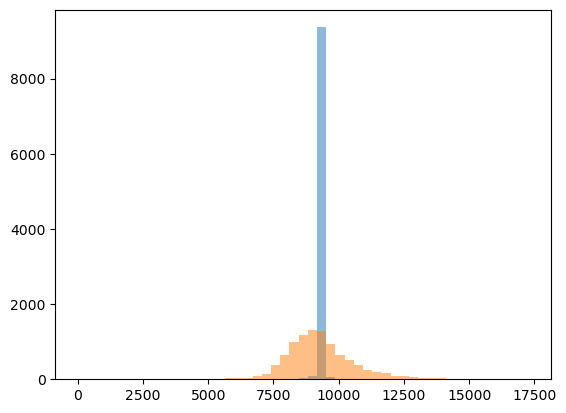

In [13]:
plt.hist(train["oof"], bins=np.linspace(0, 60 * 60 * 24 // 5, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 60 * 60 * 24 // 5, 50), alpha=0.5)
plt.show()